<a href="https://colab.research.google.com/github/nicole-mulela/AutoFarm/blob/main/NPK_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic regression: Predict N-P-K from Temperature, Humidity and pH

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [78]:
# Use seaborn for pairplot.
!pip install -q seaborn
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 6.9 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 278 kB 65.9 MB/s 
     |████████████████████████████████| 84 kB 1.1 MB/s 
     |████████████████████████████████| 106 kB 39.5 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 2.3 MB 35.7 MB/s 
     |████████████████████████████████| 64 kB 1.2 MB/s 
     |████████████████████████████████| 80 kB 3.5 MB/s 
     |████████████████████████████████| 68 kB 5.7 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=54552d211119311c3c8f5a0703038940f8505a0b5b74962f406c43d8aacff3eb
  Stored in direct

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gradio as gr

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


### Get the data
First download and import the dataset using pandas:

In [4]:
url = '/content/Crop_recommendation.csv'

raw_dataset = pd.read_csv(url)

In [5]:
dataset = raw_dataset.copy()

dataset.tail()

,N,P,K,temperature,humidity,ph,rainfall,label
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee
2199,104,18,30,23.603016,60.396475,6.779833,140.937041,coffee


In [6]:
dataset.pop('rainfall')
dataset.pop('label')
dataset.pop('humidity')

dataset.tail()

,N,P,K,temperature,ph
2195,107,34,32,26.774637,6.780064
2196,99,15,27,27.417112,6.086922
2197,118,33,30,24.131797,6.362608
2198,117,32,34,26.272418,6.758793
2199,104,18,30,23.603016,6.779833


### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

n_train_labels = train_features.pop('N')
p_train_labels = train_features.pop('P')
k_train_labels = train_features.pop('K')

n_test_labels = test_features.pop('N')
p_test_labels = test_features.pop('P')
k_test_labels = test_features.pop('K')

In [9]:
train_features

,temperature,ph
1320,26.214884,6.419052
1367,24.644585,6.343943
1291,9.724458,6.158689
264,17.257695,7.840339
728,34.946616,7.162358
...,...,...
1393,26.633312,6.560444
1298,18.706791,6.209928
339,19.636535,5.821650
1443,27.824245,6.266209


## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
N,50.465341,36.741479
P,53.440909,33.001782
K,48.227273,50.647233
temperature,25.663827,5.159153
ph,6.454532,0.774215


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [12]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [13]:
print(normalizer.mean.numpy())

[[25.664  6.455]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [14]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[26.21  6.42]]

Normalized: [[ 0.11 -0.05]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [15]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [16]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [17]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 105ms/step


array([[ 0.016],
       [ 0.134],
       [ 0.763],
       [-1.026],
       [-0.94 ],
       [-0.373],
       [ 1.189],
       [ 0.974],
       [-0.021],
       [ 0.525]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [18]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.158],
       [-0.717]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [19]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [20]:
%%time
history = linear_model.fit(
    train_features,
    n_train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 10.9 s, sys: 489 ms, total: 11.3 s
Wall time: 15 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

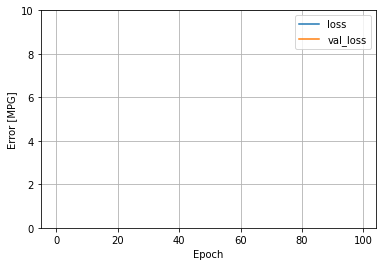

In [21]:
plot_loss(history)

In [22]:
print(history)

Collect the results on the test set for later:

In [23]:
test_results = {}

In [40]:
test_results['n_linear_model'] = linear_model.evaluate(
    test_features, n_test_labels, verbose=0)
print(test_results['n_linear_model'])


31.66718292236328


In [41]:
test_results['p_linear_model'] = linear_model.evaluate(
    test_features, p_test_labels, verbose=0)
print(test_results['p_linear_model'])

26.13930892944336


In [42]:
test_results['k_linear_model'] = linear_model.evaluate(
    test_features, k_test_labels, verbose=0)
print(test_results['k_linear_model'])

28.993356704711914


## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [27]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [43]:
n_dnn_model = build_and_compile_model(normalizer)
n_dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,422
Trainable params: 4,417
Non-trainable params: 5
_________________________________________________________________


In [44]:
p_dnn_model = build_and_compile_model(normalizer)
k_dnn_model = build_and_compile_model(normalizer)

In [45]:
%%time
n_history = n_dnn_model.fit(
    train_features,
    n_train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 11 s, sys: 738 ms, total: 11.8 s
Wall time: 20.8 s


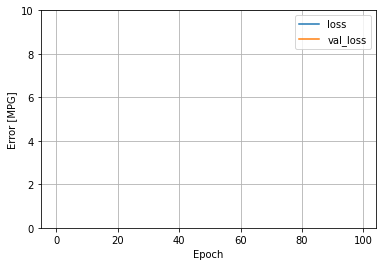

In [30]:
plot_loss(n_history)

In [46]:
%%time
p_history = p_dnn_model.fit(
    train_features,
    p_train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 12 s, sys: 713 ms, total: 12.7 s
Wall time: 12.7 s


In [47]:
%%time
k_history = k_dnn_model.fit(
    train_features,
    k_train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 10.8 s, sys: 722 ms, total: 11.5 s
Wall time: 10.2 s


Collect the results on the test set:

In [48]:
test_results['n_dnn_model'] = n_dnn_model.evaluate(test_features, n_test_labels, verbose=0)

In [49]:
print(test_results['n_dnn_model'])

27.851240158081055


In [50]:
test_results['p_dnn_model'] = p_dnn_model.evaluate(test_features, p_test_labels, verbose=0)

In [51]:
print(test_results['p_dnn_model'])

23.587688446044922


In [52]:
test_results['k_dnn_model'] = k_dnn_model.evaluate(test_features, k_test_labels, verbose=0)

In [53]:
print(test_results['k_dnn_model'])

26.2831974029541


## Performance

Since all models have been trained, you can review their test set performance:

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,28.993357
dnn_model,26.219664
reloaded,32.524948
n_linear_model,31.667183
p_linear_model,26.139309
k_linear_model,28.993357
n_dnn_model,27.851240
p_dnn_model,23.587688
k_dnn_model,26.283197


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

14/14 [==============================] - 0s 1ms/step


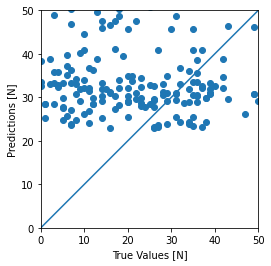

In [57]:
n_test_predictions = n_dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(n_test_labels, n_test_predictions)
plt.xlabel('True Values [N]')
plt.ylabel('Predictions [N]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

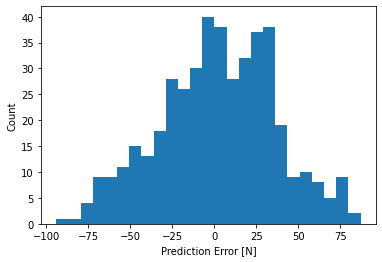

In [58]:
error = n_test_predictions - n_test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [N]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

14/14 [==============================] - 0s 2ms/step


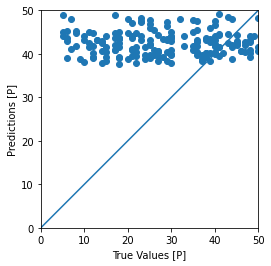

In [62]:
p_test_predictions = p_dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(p_test_labels, p_test_predictions)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

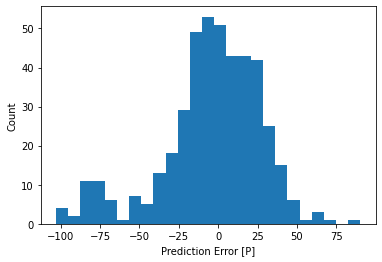

In [63]:
error = p_test_predictions - p_test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [P]')
_ = plt.ylabel('Count')

14/14 [==============================] - 0s 1ms/step


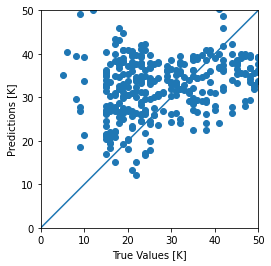

In [64]:
k_test_predictions = k_dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(k_test_labels, k_test_predictions)
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

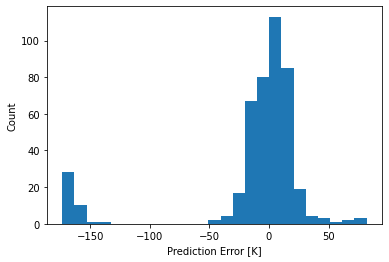

In [65]:
error = k_test_predictions - k_test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [K]')
_ = plt.ylabel('Count')

In [59]:
n_dnn_model.save('n_dnn_model')

In [66]:
p_dnn_model.save('p_dnn_model')

In [67]:
k_dnn_model.save('k_dnn_model')

If you reload the model, it gives identical output:

In [68]:
n_reloaded = tf.keras.models.load_model('n_dnn_model')

test_results['n_reloaded'] = n_reloaded.evaluate(
    test_features, n_test_labels, verbose=0)

In [72]:
p_reloaded = tf.keras.models.load_model('p_dnn_model')

test_results['p_reloaded'] = p_reloaded.evaluate(
    test_features, p_test_labels, verbose=0)

In [70]:
k_reloaded = tf.keras.models.load_model('k_dnn_model')

test_results['k_reloaded'] = k_reloaded.evaluate(
    test_features, k_test_labels, verbose=0)

In [73]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,28.993357
dnn_model,26.219664
reloaded,23.587688
n_linear_model,31.667183
p_linear_model,26.139309
k_linear_model,28.993357
n_dnn_model,27.851240
p_dnn_model,23.587688
k_dnn_model,26.283197
n_reloaded,27.851240


In [113]:
def npk(Temperature, PH):
#turning the arguments into a numpy array  

  x = np.array([Temperature, PH])

  n_prediction = n_dnn_model.predict(x.reshape(1, -1))
  p_prediction = p_dnn_model.predict(x.reshape(1, -1))
  k_prediction = k_dnn_model.predict(x.reshape(1, -1))

  return round(float(n_prediction),2), round(float(p_prediction),2), round(float(k_prediction),2)


In [117]:
def n(Temperature, PH):
#turning the arguments into a numpy array  

  x = np.array([Temperature, PH])

  n_prediction = n_dnn_model.predict(x.reshape(1, -1))

  return round(float(n_prediction),2)


In [118]:
def p(Temperature, PH):
#turning the arguments into a numpy array  

  x = np.array([Temperature, PH])

  p_prediction = p_dnn_model.predict(x.reshape(1, -1))

  return round(float(p_prediction),2)

In [119]:
def k(Temperature, PH):
#turning the arguments into a numpy array  

  x = np.array([Temperature, PH])

  k_prediction = k_dnn_model.predict(x.reshape(1, -1))

  return round(float(k_prediction),2)

In [105]:
print(round(5.78789,2))

5.79


In [114]:
npk(25,5.5)

1/1 [==============================] - 0s 24ms/step


(42.13, 50.8, 31.46)

In [121]:
app = gr.Interface(fn=npk, inputs=['number','number'], outputs=['number','number','number'],description="This is an NPK Prediction model")

In [116]:
app.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.